# Modélisation - Prédiction de l'attrition

## Contexte

Nous testons successivement :
1. Une approche baseline
2. Une pondération des classes
3. Un sur-échantillonnage SMOTE

## Stratégie de modélisation

Nous testons successivement :
1. Une approche baseline
2. Une pondération des classes
3. Un sur-échantillonnage SMOTE


## Premier modèle de classification


### Setup du notebook et chargement des données


In [ ]:
import pandas as pd
import preprocessing as pp
import modelization as md
import visualizer as vi
import matplotlib.pyplot as plt

#Selection
from sklearn.model_selection import (
	train_test_split,
	StratifiedKFold
)
#Modèles
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline  # Pipeline compatible imblearn
from imblearn.over_sampling import SMOTE

from sklearn.metrics import (
	make_scorer, recall_score, precision_score, f1_score,
	RocCurveDisplay, PrecisionRecallDisplay
)

df = pd.read_csv("data/data_clean.csv")

TARGET = 'a_quitte_l_entreprise'
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_SPLIT = 5

X, y, preprocessor = pp.prepare_ml_data(
    df,
    target=TARGET,
    binary_ordinal_features=['genre', 'heure_supplementaires', 'frequence_deplacement']
)

### Inspection des données d'entrée

Avant de modéliser, vérifions la structure des données préparées à l'étape 2 : dimensions de X et y, types de features détectés par le preprocessor, et aperçu des premières lignes.

In [2]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'str']).columns.tolist()

print(f"Dimensions : X = {X.shape}, y = {y.shape}")
print(f"\nFeatures numériques ({len(numeric_features)}) : {numeric_features}")
print(f"\nFeatures catégorielles ({len(categorical_features)}) : {categorical_features}")
print(f"\nDistribution de la cible :")
print(y.value_counts().rename(index={0: 'Reste', 1: 'Quitte'}))

display(X.head())

Dimensions : X = (1470, 27), y = (1470,)

Features numériques (24) : ['age', 'genre', 'revenu_mensuel', 'nombre_experiences_precedentes', 'annee_experience_totale', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_actuelle', 'heure_supplementaires', 'augmentation_salaire_precedente', 'nombre_participation_pee', 'nb_formations_suivies', 'distance_domicile_travail', 'niveau_education', 'frequence_deplacement', 'annees_depuis_la_derniere_promotion', 'annees_sous_responsable_actuel', 'mobilite_interne', 'age_debut_carriere', 'score_satisfaction_global']

Features catégorielles (3) : ['statut_marital', 'poste', 'domaine_etude']

Distribution de la cible :
a_quitte_l_entreprise
Reste     1233
Quitte     237
Name: count, dtype: int64


,age,genre,revenu_mensuel,statut_marital,poste,nombre_experiences_precedentes,annee_experience_totale,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,...,nb_formations_suivies,distance_domicile_travail,niveau_education,domaine_etude,frequence_deplacement,annees_depuis_la_derniere_promotion,annees_sous_responsable_actuel,mobilite_interne,age_debut_carriere,score_satisfaction_global
0,41,0,5993,Célibataire,Cadre Commercial,8,8,4,2,3,...,0,1,2,Infra & Cloud,1,0,5,2,33,2.00
1,49,1,5130,Marié(e),Assistant de Direction,1,10,7,3,2,...,3,8,1,Infra & Cloud,2,1,7,3,39,3.00
2,37,1,2090,Célibataire,Consultant,6,7,0,4,2,...,3,2,2,Autre,1,0,0,0,30,3.00
3,33,0,2909,Marié(e),Assistant de Direction,1,8,7,4,3,...,3,3,4,Infra & Cloud,2,3,0,1,25,3.25
4,27,1,3468,Marié(e),Consultant,9,6,2,1,3,...,3,2,1,Transformation Digitale,1,2,2,0,21,2.50


### Séparation train/test

Le découpage train/test est réalisé avec l’option `stratify=y` afin de préserver la distribution des classes dans les deux ensembles, ce qui est essentiel compte tenu du fort déséquilibre du jeu de données, et permet d’obtenir une évaluation plus représentative des performances du modèle.

Nous réservons 20% des données comme jeu de test pour l'évaluation finale des modèles, et nous appliquerons une validation croisée sur le jeu de train.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
	stratify=y
)

### Distribution des classes

Avant d'entraîner nos modèles, il est essentiel de quantifier le déséquilibre entre les classes. Un ratio fortement déséquilibré impacte directement le choix des métriques et la stratégie de modélisation.

Distribution globale :
a_quitte_l_entreprise
Reste     1233
Quitte     237
Name: count, dtype: int64

Proportion :
a_quitte_l_entreprise
Reste     83.9%
Quitte    16.1%
Name: proportion, dtype: str

Ratio déséquilibre : 1 Quitte pour 5.2 Reste


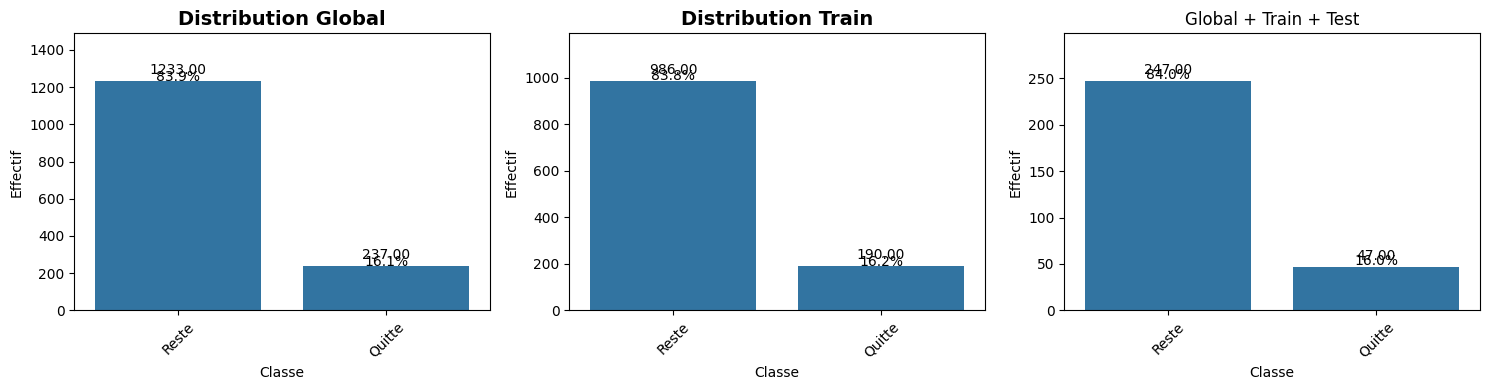

In [4]:
class_labels = {0: 'Reste', 1: 'Quitte'}

print("Distribution globale :")
print(y.value_counts().rename(index=class_labels))
print(f"\nProportion :")
print(y.value_counts(normalize=True).rename(index=class_labels).map(lambda x: f"{x:.1%}"))
print(f"\nRatio déséquilibre : 1 Quitte pour {y.value_counts()[0] / y.value_counts()[1]:.1f} Reste")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (data, title) in zip(axes, [
    (y, "Global"), (y_train, "Train"), (y_test, "Test")
]):
    counts = data.value_counts().rename(index=class_labels)
    df_counts = pd.DataFrame({'Classe': counts.index, 'Effectif': counts.values})
    vi.create_barplot(
        df_counts, ax, x='Classe', y='Effectif',
        title=f'Distribution {title}'
    )
    for i, (label, count) in enumerate(counts.items()):
        pct = count / len(data)
        ax.text(i, count + 2, f"{pct:.1%}", ha='center', fontsize=10)
plt.title("Global + Train + Test")
plt.tight_layout()
plt.show()

### Choix des modèles

L’objectif est de prédire si un employé va quitter l’entreprise : il s’agit donc d’un problème de **classification binaire**.

Pour comparer différentes approches, quatre modèles ont été évalués :

- **DummyClassifier**  
  Sert de baseline avec la stratégie `most_frequent`, qui prédit systématiquement la classe majoritaire.  
  Cela permet d’établir un niveau minimal de performance et de vérifier que les modèles entraînés apportent un réel gain.

- **LogisticRegression**  
  Modèle linéaire simple, rapide et interprétable, utilisé comme première approche supervisée.

- **RandomForestClassifier**  
  Modèle non linéaire basé sur un ensemble d’arbres de décision, capable de capturer des relations complexes entre les variables.

- **XGBClassifier**  
  Modèle de gradient boosting qui entraîne les arbres séquentiellement, chaque nouvel arbre corrigeant les erreurs du précédent.

In [ ]:
pipelines = {
    "Dummy": Pipeline([
        ('preprocessor', preprocessor),
        ('model', DummyClassifier(strategy="most_frequent"))
    ]),
	"LR_baseline": Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
    ]),
    "RF_baseline": Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(random_state=RANDOM_STATE))
    ]),
    "XGB_baseline": Pipeline([
        ('preprocessor', preprocessor),
        ('model', XGBClassifier(random_state=RANDOM_STATE))
    ])
}

### Choix de la métrique principale

#### 1. Contexte du problème

Le projet vise à prédire le départ potentiel des employés (**attrition**), un problème de classification binaire caractérisé par un **déséquilibre marqué des classes**, la majorité des employés restant dans l’entreprise.

Dans ce contexte, l’évaluation des modèles ne peut pas reposer sur une métrique unique et doit prendre en compte à la fois la performance statistique et l’impact métier.


#### 2. Métriques évaluées

Plusieurs métriques sont utilisées afin d’analyser les performances des modèles sous différents angles :

- **Accuracy**  
  Proportion totale de prédictions correctes.  
  → Peu informative en cas de déséquilibre des classes, car elle favorise la classe majoritaire.

- **Precision (classe "Quitte")**  
  Proportion d’employés effectivement partis parmi ceux prédits comme partants.  
  → Mesure la fiabilité des alertes générées par le modèle.

- **Recall (classe "Quitte")**  
  Proportion d’employés ayant quitté l’entreprise correctement identifiés par le modèle.  
  → Mesure la capacité du modèle à détecter les départs.

- **F1-score (classe "Quitte")**  
  Moyenne harmonique entre precision et recall.  
  → Permet d’évaluer le compromis entre détection des départs et limitation des fausses alertes.

- **ROC-AUC**  
  Mesure la capacité du modèle à classer un employé quittant l’entreprise avec un score de risque plus élevé qu’un employé restant, indépendamment du seuil de décision.  
  → Utile pour comparer le pouvoir de discrimination global des modèles, mais peut être optimiste en contexte fortement déséquilibré.

- **PR-AUC (Area Under the Precision–Recall Curve)**  
  Synthétise le compromis précision/rappel sur la classe minoritaire.  
  → Particulièrement adaptée aux jeux de données déséquilibrés et plus représentative de la performance réelle sur la classe "Quitte".

Dans les résultats présentés, la **precision**, le **recall** et le **F1-score** sont calculés exclusivement sur la classe **"Quitte"** (classe positive = 1).


#### 3. Justification du choix métier

L’objectif principal du modèle est d’**identifier le plus grand nombre possible d’employés susceptibles de quitter l’entreprise**, afin de permettre aux équipes RH de mettre en place des actions préventives (entretiens, mobilité interne, revalorisation).

##### Inadéquation de l’accuracy

Un modèle prédisant systématiquement la classe majoritaire ("Reste") pourrait obtenir une accuracy élevée tout en étant inutilisable d’un point de vue opérationnel, car il ne détecterait aucun départ.

##### Priorité au recall sur la classe "Quitte"

Les coûts associés aux erreurs de classification sont asymétriques :

- **Faux négatif** (départ non détecté)  
  → Perte non anticipée, coûts élevés (recrutement, formation, perte de compétences)

- **Faux positif** (fausse alerte)  
  → Coût limité (entretien ou action RH préventive)

Cette asymétrie justifie de **privilégier le recall** sur la classe "Quitte".

##### Rôle du F1-score et de la PR-AUC

Optimiser uniquement le recall conduirait à générer un nombre excessif de fausses alertes.  
Le **F1-score** et la **PR-AUC** permettent de s’assurer que le modèle maintient un équilibre acceptable entre la capacité de détection des départs et la précision des alertes générées.

#### 4. Métrique principale retenue

Au regard du déséquilibre des classes et des enjeux métier, la **PR-AUC** est retenue comme métrique principale de comparaison des modèles, tandis que le **recall sur la classe "Quitte"** est utilisé comme indicateur clé de performance opérationnelle.


In [6]:
cv = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
    'roc_auc': 'roc_auc',
    'average_precision': 'average_precision',
}

# Évaluation sur le jeu de validation
class_names = ['Reste', 'Quitte']

all_cv_results_baseline = {}
all_eval_results_baseline = {}
for model_name, pipeline in pipelines.items():
    results = md.cross_validate_model(pipeline, X_train, y_train, cv=cv, scoring=scoring)
    all_cv_results_baseline[model_name] = results
    eval_results = md.evaluate_model(pipeline, X_train, y_train, X_test, y_test)
    all_eval_results_baseline[model_name] = eval_results


df_all_results_baseline = md.build_comparison_df(all_cv_results=all_cv_results_baseline, all_eval_results=all_eval_results_baseline)

def display_summary_results(df: pd.DataFrame):
    df = df.copy()
    summary_rows = []
    for model_name in df.index:
        row = {'Modèle': model_name}
        for metric in ['average_precision', 'recall', 'precision', 'f1']:
            mean = df.loc[model_name, f'cv_test_{metric}']
            std = df.loc[model_name, f'cv_test_{metric}_std']
            display_name = 'PR-AUC' if metric == 'average_precision' else metric
            row[f'CV {display_name}'] = f"{mean:.3f} ± {std:.3f}"
            test_col = f'test_pr_auc' if metric == 'average_precision' else f'test_{metric}'
            row[f'Test {display_name}'] = f"{df.loc[model_name, test_col]:.3f}"
        summary_rows.append(row)

    df_summary = pd.DataFrame(summary_rows).set_index('Modèle')
    display(df_summary)

display_summary_results(df_all_results_baseline)

,CV PR-AUC,Test PR-AUC,CV recall,Test recall,CV precision,Test precision,CV f1,Test f1
Modèle,,,,,,,,
Dummy,0.162 ± 0.000,0.160,0.000 ± 0.000,0.000,0.000 ± 0.000,0.000,0.000 ± 0.000,0.000
LR_baseline,0.662 ± 0.065,0.605,0.442 ± 0.084,0.362,0.770 ± 0.065,0.654,0.558 ± 0.077,0.466
RF_baseline,0.548 ± 0.086,0.421,0.216 ± 0.100,0.149,0.850 ± 0.134,0.538,0.330 ± 0.125,0.233
XGB_baseline,0.571 ± 0.037,0.463,0.374 ± 0.056,0.234,0.723 ± 0.043,0.500,0.489 ± 0.046,0.319


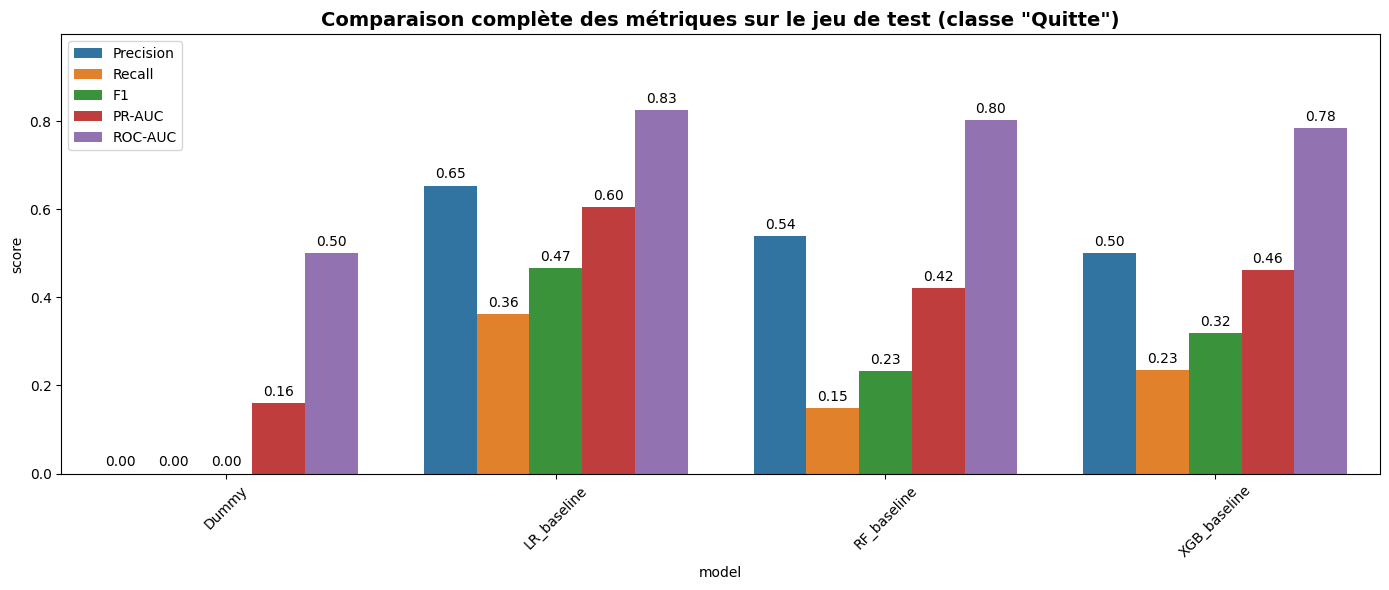

In [7]:
fig, ax = plt.subplots(figsize=(14, 6))
vi.plot_metrics_comparison(
    df_all_results_baseline, ax,
    title='Comparaison complète des métriques sur le jeu de test (classe "Quitte")'
)
plt.tight_layout()
plt.show()


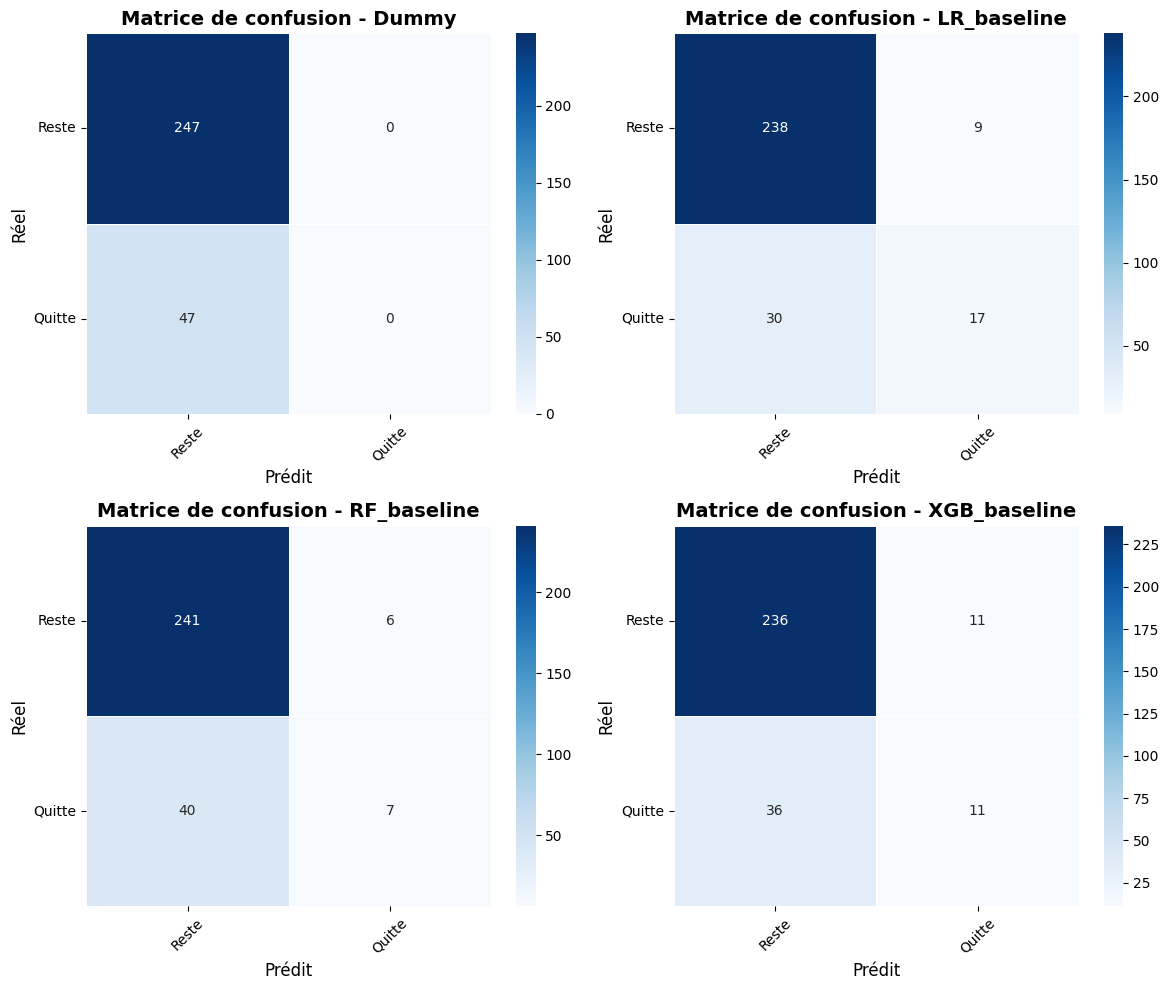

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for ax, (name, res) in zip(axes.flatten(), all_eval_results_baseline.items()):
    cm_df = pd.DataFrame(res['confusion_matrix'], 
                         index=class_names, columns=class_names)
    vi.create_heatmap(cm_df, ax, fmt='d', cmap='Blues',
                   title=f'Matrice de confusion - {name}',
                   xlabel='Prédit', ylabel='Réel')
plt.tight_layout()
plt.show()

**La courbe précision–rappel** permet de visualiser le compromis entre le nombre de départs détectés et le nombre de fausses alertes, en fonction du seuil de décision. Elle est particulièrement adaptée aux problèmes déséquilibrés comme l’attrition, car elle met l’accent sur la classe minoritaire.

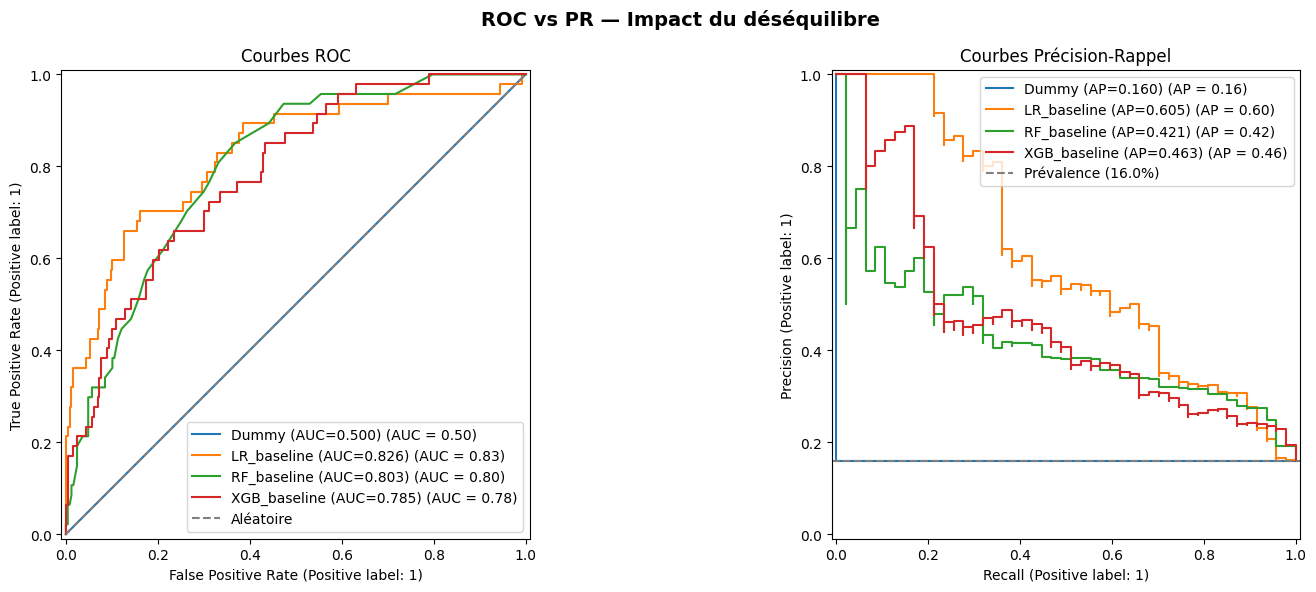

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for name, res in all_eval_results_baseline.items():
    y_proba = res.get('y_proba')
    if y_proba is None:
        continue

    RocCurveDisplay.from_predictions(
        y_test, y_proba,
        name=f"{name} (AUC={res['roc_auc']:.3f})",
        ax=axes[0]
    )
    PrecisionRecallDisplay.from_predictions(
        y_test, y_proba,
        name=f"{name} (AP={res['pr_auc']:.3f})",
        ax=axes[1]
    )

axes[0].plot([0, 1], [0, 1], 'grey', linestyle='--', label='Aléatoire')
axes[0].set_title("Courbes ROC")
axes[0].legend(loc='lower right')

prevalence = y_test.mean()
axes[1].axhline(y=prevalence, color='grey', linestyle='--',
                label=f'Prévalence ({prevalence:.1%})')
axes[1].set_title("Courbes Précision-Rappel")
axes[1].legend(loc='upper right')

plt.suptitle("ROC vs PR — Impact du déséquilibre", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


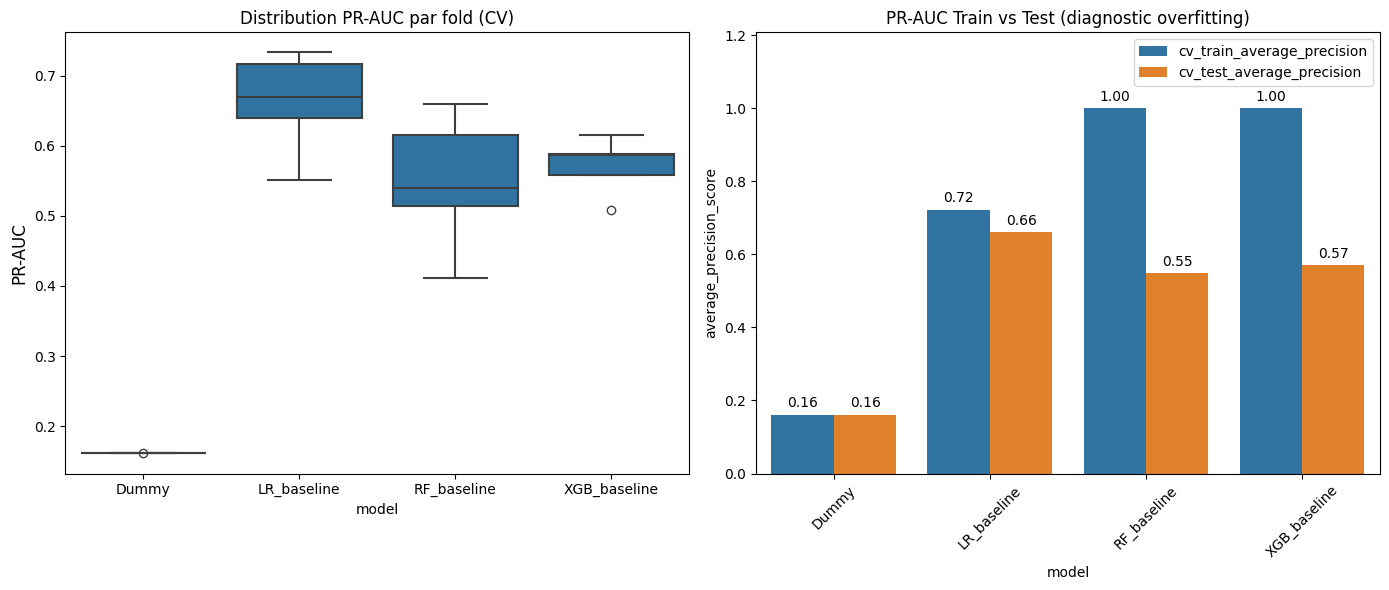

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
vi.visualize_cv_results(axes, all_cv_results_baseline, df_all_results_baseline, metric='average_precision')
axes[0].set_title("Distribution PR-AUC par fold (CV)")
axes[0].set_ylabel("PR-AUC")
axes[1].set_title("PR-AUC Train vs Test (diagnostic overfitting)")
plt.tight_layout()
plt.show()



**Observation – Validation croisée et overfitting**


## Amélioration de l'approche

#### Gestion du déséquilibre des classes

- `class_weight='balanced'` ajuste automatiquement les poids des classes afin de compenser leur déséquilibre.

- `scale_pos_weight` (équivalent XGBoost) augmente le poids de la classe minoritaire (*Quitte*) dans la fonction de perte.  
  Il est calculé comme : **n_reste / n_quitte**. Cela force le modèle à accorder davantage d’importance aux erreurs sur les départs d’employés.


In [11]:
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

pipelines_balanced = {
	"LR_balanced": Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE, max_iter=1000))
    ]),
    "RF_balanced": Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE))
    ]),
    "XGB_balanced": Pipeline([
        ('preprocessor', preprocessor),
        ('model', XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=RANDOM_STATE))
    ])
}

all_cv_results_balanced = {}
all_eval_results_balanced = {}

for model_name, pipeline in pipelines_balanced.items():
    results = md.cross_validate_model(pipeline, X_train, y_train, cv=cv, scoring=scoring)
    all_cv_results_balanced[model_name] = results
    eval_results = md.evaluate_model(pipeline, X_train, y_train, X_test, y_test)
    all_eval_results_balanced[model_name] = eval_results

df_all_results_balanced = md.build_comparison_df(
    all_cv_results=all_cv_results_balanced, 
    all_eval_results=all_eval_results_balanced
)

display_summary_results(df_all_results_balanced)

,CV PR-AUC,Test PR-AUC,CV recall,Test recall,CV precision,Test precision,CV f1,Test f1
Modèle,,,,,,,,
LR_balanced,0.638 ± 0.070,0.598,0.737 ± 0.069,0.723,0.384 ± 0.025,0.391,0.503 ± 0.018,0.507
RF_balanced,0.547 ± 0.053,0.393,0.163 ± 0.090,0.128,0.884 ± 0.106,0.429,0.261 ± 0.128,0.197
XGB_balanced,0.583 ± 0.047,0.491,0.405 ± 0.036,0.383,0.652 ± 0.061,0.474,0.498 ± 0.037,0.424


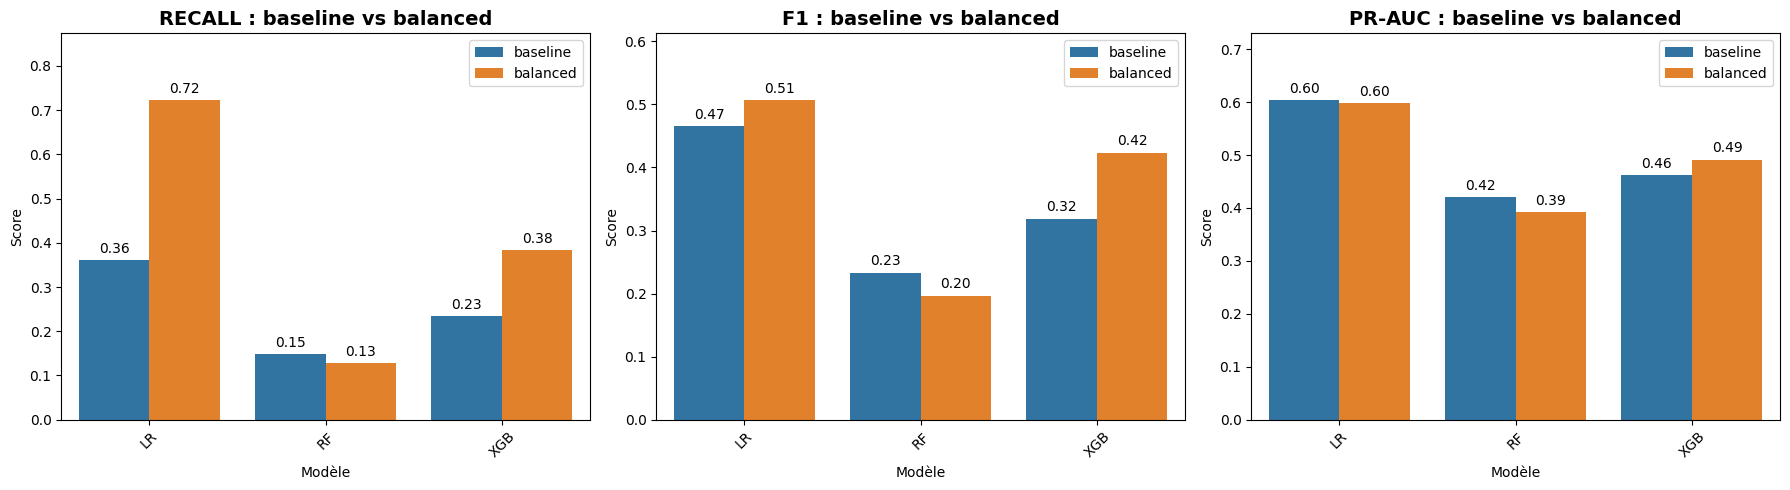

In [ ]:
df_all_results_combined = pd.concat([
    df_all_results_baseline, 
    df_all_results_balanced
])

comparisons = [
    ('LR_baseline', 'LR_balanced', 'LR'),
    ('RF_baseline', 'RF_balanced', 'RF'),
    ('XGB_baseline', 'XGB_balanced', 'XGB'),
]


rows = []
for base_name, balanced_name, short in comparisons:
    for metric in ['test_pr_auc', 'test_recall', 'test_f1']:
        label = metric.replace('test_', '').upper().replace('_', '-')
        rows.append({
            'Modèle': short, 'Version': 'baseline',
            'Métrique': label,
            'Score': df_all_results_combined.loc[base_name, metric]
        })
        rows.append({
            'Modèle': short, 'Version': 'balanced',
            'Métrique': label,
            'Score': df_all_results_combined.loc[balanced_name, metric]
        })

df_comp = pd.DataFrame(rows)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, metric_label in zip(axes, ['RECALL', 'F1', 'PR-AUC']):
    subset = df_comp[df_comp['Métrique'] == metric_label]
    vi.create_barplot(
        subset, ax, x='Modèle', y='Score', hue='Version',
        title=f'{metric_label} : baseline vs balanced'
    )
plt.tight_layout()
plt.show()

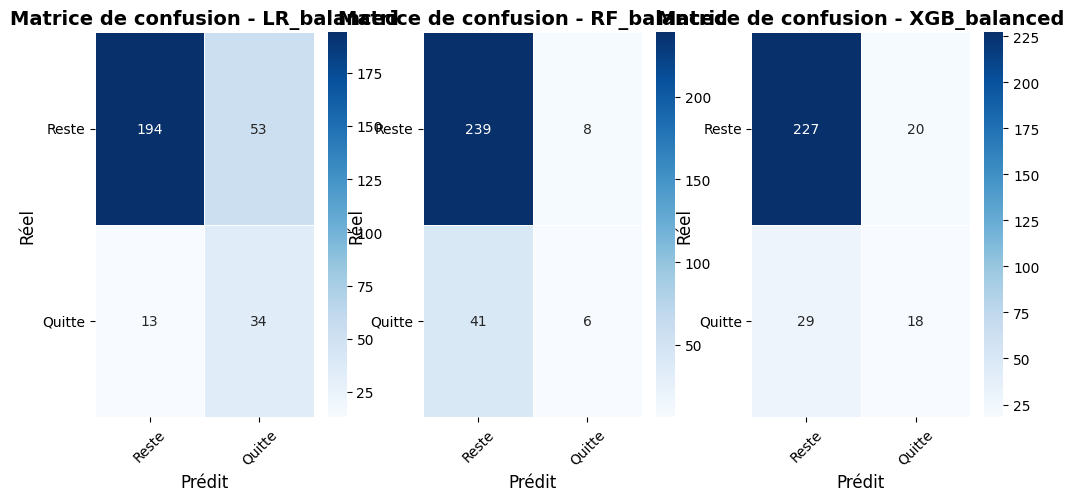

In [13]:
# Matrices de confusion
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
for ax, (name, res) in zip(axes, all_eval_results_balanced.items()):
    cm_df = pd.DataFrame(res['confusion_matrix'], 
                         index=class_names, columns=class_names)
    vi.create_heatmap(cm_df, ax, fmt='d', cmap='Blues',
                   title=f'Matrice de confusion - {name}',
                   xlabel='Prédit', ylabel='Réel')



## SMOTE (Synthetic Minority Over-sampling Technique)

SMOTE est une technique de sur-échantillonnage qui génère des exemples synthétiques de la classe minoritaire. Contrairement au simple oversampling qui duplique les observations existantes, SMOTE crée de nouveaux points en interpolant entre des voisins proches.

**Pourquoi tester SMOTE ?**
- `class_weight='balanced'` n'a pas fonctionné pour le Random Forest
- SMOTE peut aider les modèles à mieux apprendre les frontières de décision de la classe minoritaire

**Important** : SMOTE doit être appliqué uniquement sur le jeu d'entraînement (jamais sur le test) pour éviter la fuite de données.


In [ ]:
smote = SMOTE(random_state=RANDOM_STATE)

pipelines_smote = {
    "LR_SMOTE": ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('model', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
    ]),
    "RF_SMOTE": ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('model', RandomForestClassifier(random_state=RANDOM_STATE))
    ]),
    "XGB_SMOTE": ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('model', XGBClassifier(random_state=RANDOM_STATE))
    ])
}

all_cv_results_smote = {}
all_eval_results_smote = {}

for model_name, pipeline in pipelines_smote.items():
    results = md.cross_validate_model(pipeline, X_train, y_train, cv=cv, scoring=scoring)
    all_cv_results_smote[model_name] = results
    eval_results = md.evaluate_model(pipeline, X_train, y_train, X_test, y_test)
    all_eval_results_smote[model_name] = eval_results

df_all_results_smote = md.build_comparison_df(
    all_cv_results=all_cv_results_smote, 
    all_eval_results=all_eval_results_smote
)

display_summary_results(df_all_results_smote)

,CV PR-AUC,Test PR-AUC,CV recall,Test recall,CV precision,Test precision,CV f1,Test f1
Modèle,,,,,,,,
LR_SMOTE,0.628 ± 0.071,0.593,0.732 ± 0.071,0.660,0.408 ± 0.025,0.425,0.521 ± 0.021,0.517
RF_SMOTE,0.582 ± 0.083,0.473,0.284 ± 0.110,0.277,0.736 ± 0.087,0.619,0.400 ± 0.126,0.382
XGB_SMOTE,0.576 ± 0.057,0.496,0.353 ± 0.072,0.298,0.612 ± 0.078,0.583,0.446 ± 0.077,0.394


**Observation**


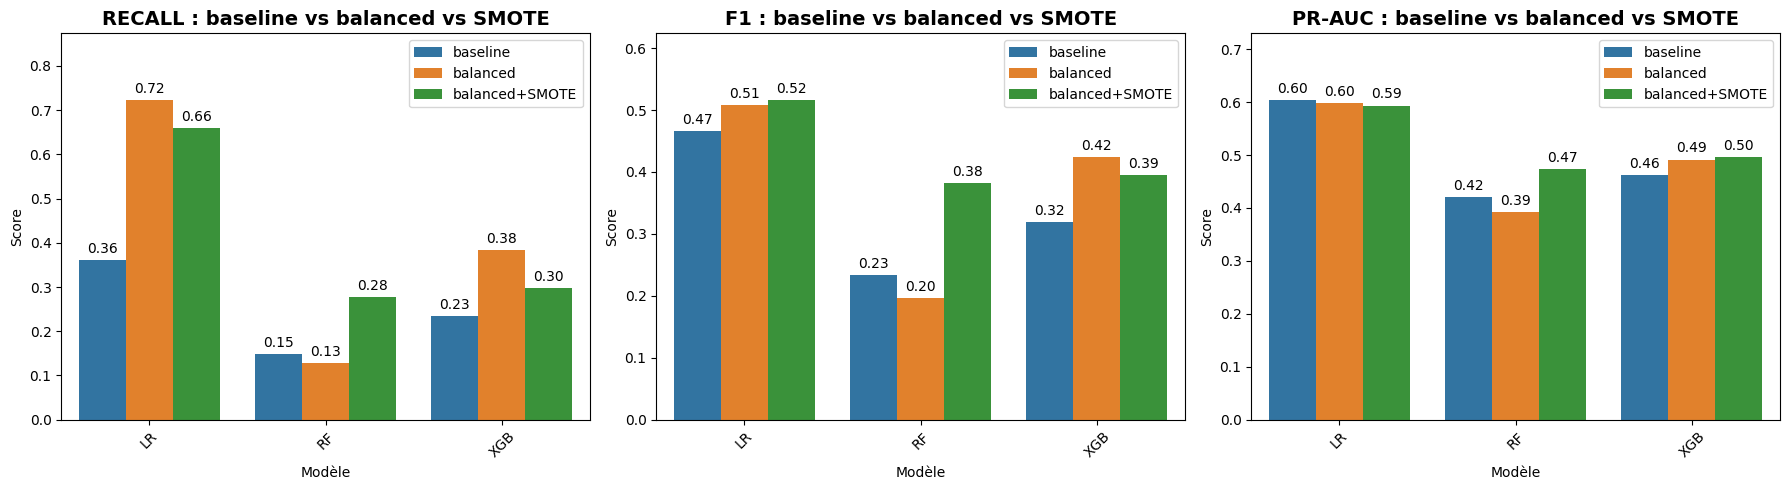

In [15]:
df_all_results_combined = pd.concat([
    df_all_results_baseline, 
    df_all_results_balanced, 
    df_all_results_smote
])

comparisons = [
    ('LR_baseline', 'LR_balanced', 'LR_SMOTE', 'LR'),
    ('RF_baseline', 'RF_balanced', 'RF_SMOTE', 'RF'),
    ('XGB_baseline', 'XGB_balanced', 'XGB_SMOTE', 'XGB'),
]


rows = []
for base_name, balanced_name, smote_name, short in comparisons:
    for metric in ['test_recall', 'test_f1', 'test_pr_auc']:
        label = metric.replace('test_', '').upper().replace('_', '-')
        rows.append({
            'Modèle': short, 'Version': 'baseline',
            'Métrique': label,
            'Score': df_all_results_combined.loc[base_name, metric]
        })
        rows.append({
            'Modèle': short, 'Version': 'balanced',
            'Métrique': label,
            'Score': df_all_results_combined.loc[balanced_name, metric]
        })
        rows.append({
            'Modèle': short, 'Version': 'balanced+SMOTE',
            'Métrique': label,
            'Score': df_all_results_combined.loc[smote_name, metric]
        })

df_comp = pd.DataFrame(rows)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, metric_label in zip(axes, ['RECALL', 'F1', 'PR-AUC']):
    subset = df_comp[df_comp['Métrique'] == metric_label]
    vi.create_barplot(
        subset, ax, x='Modèle', y='Score', hue='Version',
        title=f'{metric_label} : baseline vs balanced vs SMOTE'
    )
plt.tight_layout()
plt.show()


**Observation**


### Synthèse stratégie de rééchantillonnage retenue 

Le déséquilibre des classes (ratio 5:1) a été traité par trois approches : class_weight='balanced', SMOTE et analyse du seuil de classification. L'undersampling n'a pas été retenu car le jeu de données est de taille modeste (1470 lignes) : réduire la classe majoritaire à 237 échantillons entraînerait une perte d'information significative. SMOTE n'améliore pas les performances par rapport à class_weight='balanced' sur notre meilleur modèle (recall 66% vs 72%), ce qui suggère que la repondération de la fonction de coût est suffisante pour ce jeu de données. La stratégie retenue est donc class_weight='balanced' complétée par un ajustement du seuil de classification.

### Optimisation du seuil de classification

Par défaut, sklearn utilise un seuil de 0.5 pour classifier. Dans notre contexte métier où manquer un départ coûte plus cher qu'une fausse alerte, nous allons explorer des seuils plus bas pour augmenter le recall.


In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

best_pipeline = pipelines_balanced["LR_balanced"]
# Obtenir les probabilités
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

# Tester différents seuils
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]
results_threshold = []

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    results_threshold.append({
        'Seuil': thresh,
        'Precision': precision_score(y_test, y_pred_thresh, zero_division=0),
        'Recall': recall_score(y_test, y_pred_thresh, zero_division=0),
        'F1': f1_score(y_test, y_pred_thresh, zero_division=0),
        'Nb alertes': y_pred_thresh.sum()
    })

df_thresholds = pd.DataFrame(results_threshold)
display(df_thresholds)


,Seuil,Precision,Recall,F1,Nb alertes
0,0.2,0.238889,0.914894,0.378855,180
1,0.3,0.285714,0.851064,0.427807,140
2,0.4,0.330435,0.808511,0.469136,115
3,0.5,0.390805,0.723404,0.507463,87
4,0.6,0.453125,0.617021,0.522523,64


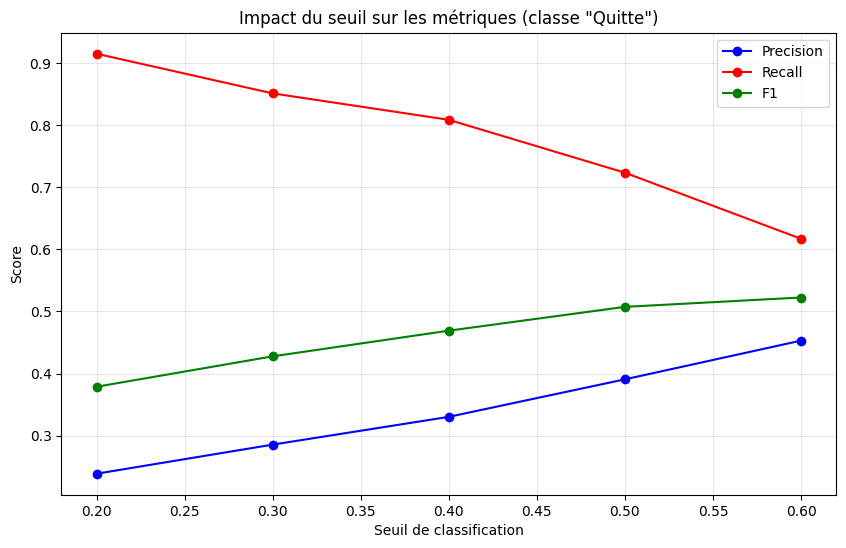

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_thresholds['Seuil'], df_thresholds['Precision'], 'b-o', label='Precision')
ax.plot(df_thresholds['Seuil'], df_thresholds['Recall'], 'r-o', label='Recall')
ax.plot(df_thresholds['Seuil'], df_thresholds['F1'], 'g-o', label='F1')

ax.set_xlabel('Seuil de classification')
ax.set_ylabel('Score')
ax.set_title('Impact du seuil sur les métriques (classe "Quitte")')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()


**Observation**

Le tableau montre le compromis classique precision/recall :
- **Seuil = 0.2** : recall très élevé (91%) mais precision faible (24%) → beaucoup de fausses alertes (180)
- **Seuil = 0.5** (défaut) : meilleur équilibre avec F1 = 0.51
- **Seuil = 0.6** : meilleur F1 (0.52) mais recall plus faible (62%)

**Choix du seuil retenu : 0.4**

Dans notre contexte RH, un départ non détecté (faux négatif) coûte significativement plus cher qu'une fausse alerte (faux positif) qui se traduit par un simple entretien préventif. Nous retenons un seuil de 0.4 qui offre le meilleur compromis :

Recall = 81% : le modèle détecte 4 départs sur 5
115 alertes à traiter, ce qui reste opérationnellement gérable pour une équipe RH
F1 = 0.47 : le gain en recall (+8 points vs seuil par défaut) se fait au prix d'une baisse modérée de precision (-6 points)
Un seuil plus bas (0.3) augmenterait le recall à 85% mais génèrerait 140 alertes avec une precision de seulement 29%, ce qui risquerait de surcharger l'équipe RH et de décrédibiliser le modèle.


Seuil par défaut (0.5)
              precision    recall  f1-score   support

       Reste       0.94      0.79      0.85       247
      Quitte       0.39      0.72      0.51        47

    accuracy                           0.78       294
   macro avg       0.66      0.75      0.68       294
weighted avg       0.85      0.78      0.80       294

Seuil retenu (0.4)
              precision    recall  f1-score   support

       Reste       0.95      0.69      0.80       247
      Quitte       0.33      0.81      0.47        47

    accuracy                           0.71       294
   macro avg       0.64      0.75      0.63       294
weighted avg       0.85      0.71      0.75       294



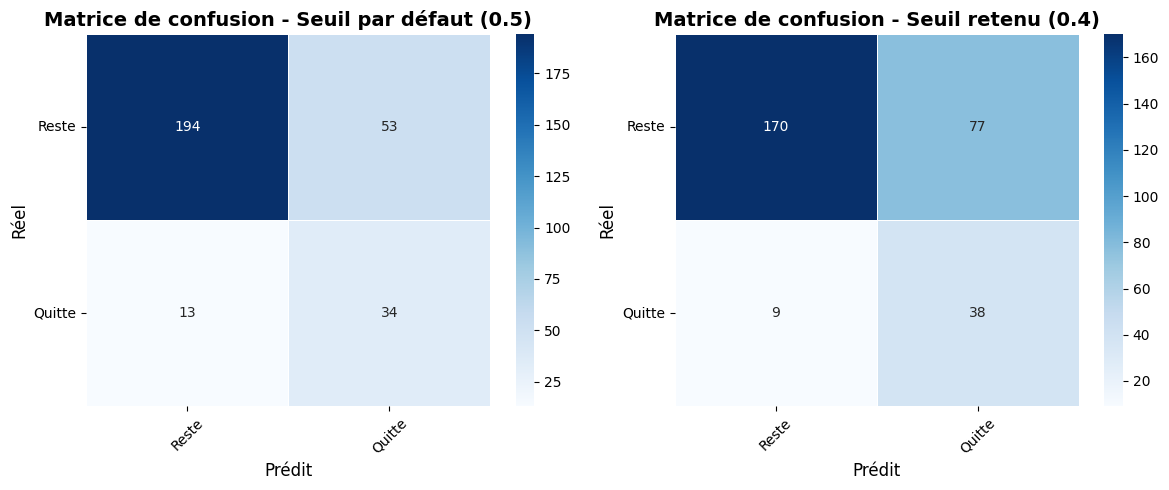

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

THRESHOLD = 0.4

# Prédictions avec le seuil retenu
y_proba_test = best_pipeline.predict_proba(X_test)[:, 1]
y_pred_adjusted = (y_proba_test >= THRESHOLD).astype(int)

# Comparaison avec le seuil par défaut
y_pred_default = best_pipeline.predict(X_test)

print("=" * 55)
print(f"Seuil par défaut (0.5)")
print("=" * 55)
print(classification_report(y_test, y_pred_default, target_names=class_names, zero_division=0))

print("=" * 55)
print(f"Seuil retenu ({THRESHOLD})")
print("=" * 55)
print(classification_report(y_test, y_pred_adjusted, target_names=class_names, zero_division=0))

# Matrices de confusion côte à côte
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, (y_pred, title) in zip(axes, [
    (y_pred_default, "Seuil par défaut (0.5)"),
    (y_pred_adjusted, f"Seuil retenu ({THRESHOLD})")
]):
    cm = pd.DataFrame(
        confusion_matrix(y_test, y_pred),
        index=class_names, columns=class_names
    )
    vi.create_heatmap(cm, ax, fmt='d', cmap='Blues',
                      title=f'Matrice de confusion - {title}',
                      xlabel='Prédit', ylabel='Réel')

plt.tight_layout()
plt.show()


**Observation**

Avec le seuil ajusté à 0.4, le modèle passe de 34 à 38 départs détectés sur 47 (+4), au prix de 28 fausses alertes supplémentaires. Ce compromis est acceptable dans notre contexte métier : chaque départ non anticipé représente un coût bien supérieur à celui d'un entretien préventif inutile.

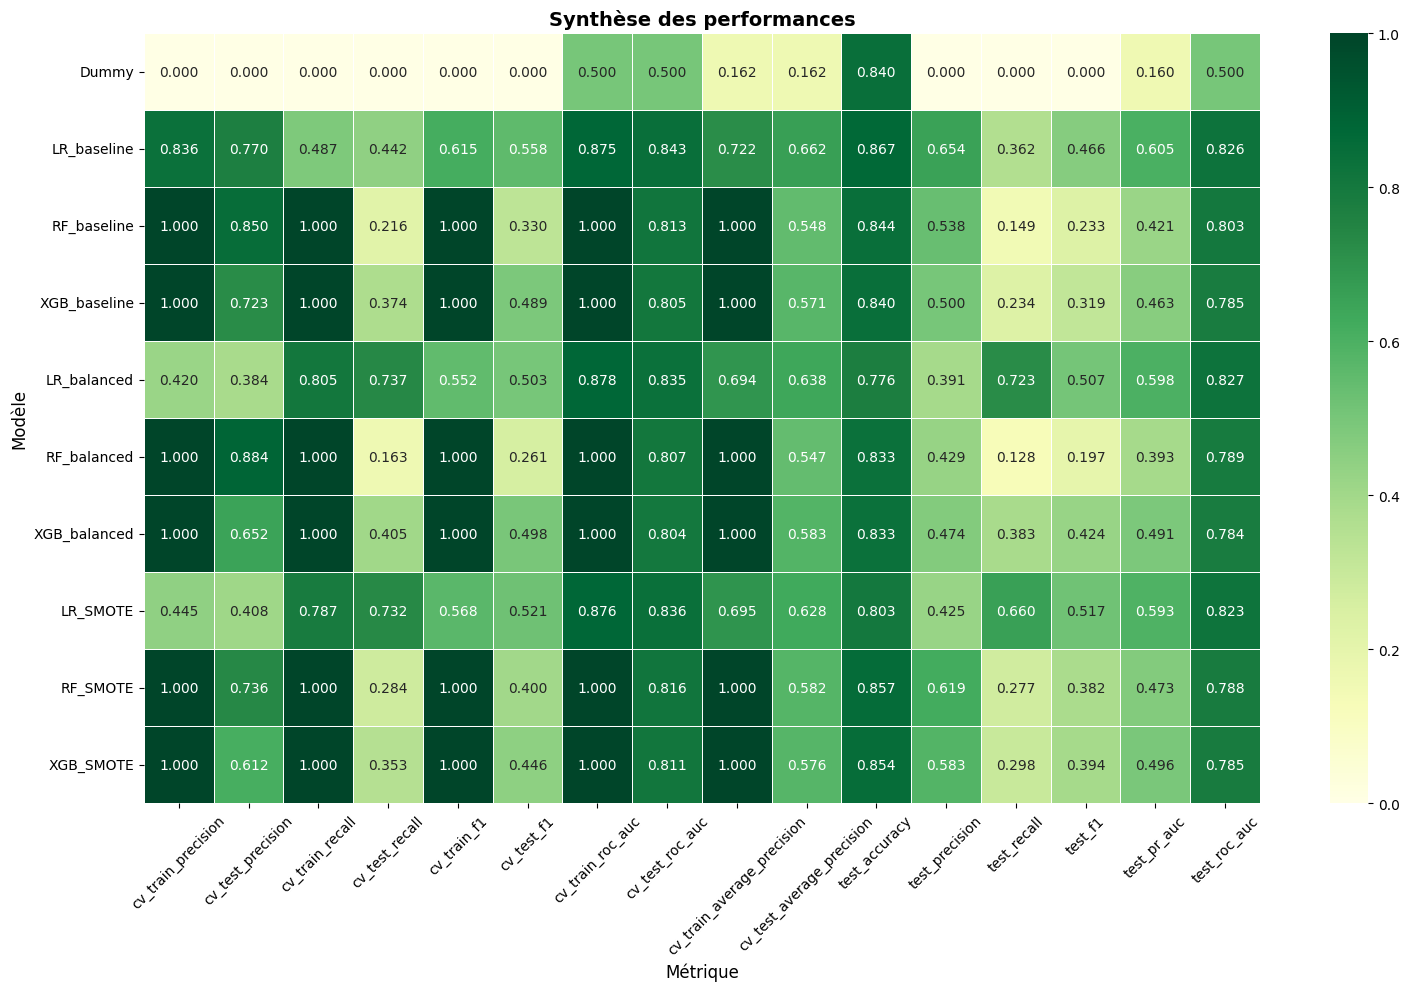

In [19]:
cols_heatmap = [c for c in df_all_results_combined.columns if c != 'cv_time_sec' and '_std' not in c]
fig, ax = plt.subplots(figsize=(18, 10))
vi.create_heatmap(df_all_results_combined[cols_heatmap], ax,
               fmt='.3f', cmap='YlGn', title='Synthèse des performances',
               xlabel='Métrique', ylabel='Modèle')

### Conclusion de l'étape 4

**Synthèse des améliorations testées :**

| Approche | Modèle | Recall (test) | Commentaire |
|----------|--------|---------------|-------------|
| Baseline | LR | 34% | Insuffisant |
| Baseline | RF | 15% | Overfitting sévère |
| class_weight='balanced' | LR | **72%** | Meilleure option |
| class_weight='balanced' | RF | 11% | Inefficace |
| SMOTE | LR | 66% | Bon mais < balanced |
| SMOTE | RF | 28% | Amélioration mais overfitting |

**Modèle retenu pour l'étape 5 : LR_balanced**
- Recall de 72% sur la classe "Quitte" (détecte 34 départs sur 47)
- Bonne stabilité en validation croisée
- Pas d'overfitting

**Prochaines étapes (Étape 5) :**
- Fine-tuning des hyperparamètres (régularisation C)
- Interprétation globale avec feature importance
- Interprétation locale avec SHAP
